In [ ]:
import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 126, 126)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    #image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes,
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cp -av /content/drive/MyDrive/'Giraffa Analytics'/'MRI-Blur-Detection'/'Data' 'preprocessed slices'

'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data' -> 'preprocessed slices'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices' -> 'preprocessed slices/preprocessed slices'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC247_nomotion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC247_nomotion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC248_motion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC248_motion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC248_nomotion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC248_nomotion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC249_motion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC249_motion.npy'
'/content/drive/MyDrive/Giraffa 

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim*2, hidden_dim*4),
            self.make_crit_block(hidden_dim*4, hidden_dim*8),
            self.make_crit_block(hidden_dim*8, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar=
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim, hidden_dim * 4, kernel_size=4, stride=3),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=5, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=5, stride=2),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=6, stride=2, final_layer=True)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        x = self.gen(x)
        return x



def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

In [ ]:
def get_input_dimensions(z_dim, img_shape=(1,28,28), n_classes=0):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = img_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
import numpy as np
from PIL import Image

def convert_image_to_shape(image_path, target_shape):
    # Open the image from the specified path
    img = Image.fromarray(np.load(image_path))

    # Convert the PIL image to grayscale if the target shape specifies a single channel
    if img.mode != 'L' and target_shape[0] == 1:
        img = img.convert('L')

    # Resize the image to the target shape (width, height)
    img_resized = np.array(img.resize((target_shape[2], target_shape[1]), Image.LANCZOS))

    return img_resized.reshape((1, target_shape[2], target_shape[1]))/255

In [ ]:
img_shape = (1, 126, 126)

In [ ]:
from PIL import Image
import os

images = []
for img_path in os.listdir('drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices'):
    #print(img_path.split('_'))
    # Load the image using Pillow
    if  ("nomotion" in img_path) and int(img_path.split('_')[1]) >= 110 and int(img_path.split('_')[1]) <=130:
      image = convert_image_to_shape(f'drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/{img_path}', target_shape=img_shape)
      images.append(torch.tensor(image).float())



In [ ]:
len(images)

609

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [ ]:
n_epochs = 70
z_dim = 128
display_step = 100
batch_size = 2
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'



In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
batch_scaler=2
for epoch in tqdm(range(n_epochs)):
    # Dataloader returns the batches
    if epoch % 20 == 0:
      if batch_size == 32:
        batch_scaler = 1
        batch_size = 16
      batch_size = int(batch_size*batch_scaler)
      dataloader = DataLoader(CustomDataset(images), batch_size=batch_size, shuffle=True)
    for real in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

torch.save(gen.state_dict(), './drive/MyDrive/GAN Stuff/generator.pth')
torch.save(crit.state_dict(), './drive/MyDrive/GAN Stuff/crit.pth')

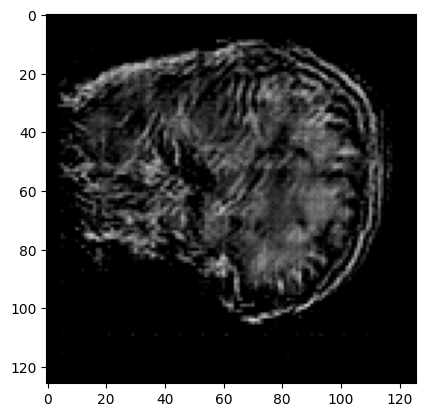

In [ ]:
show_tensor_images(fake)

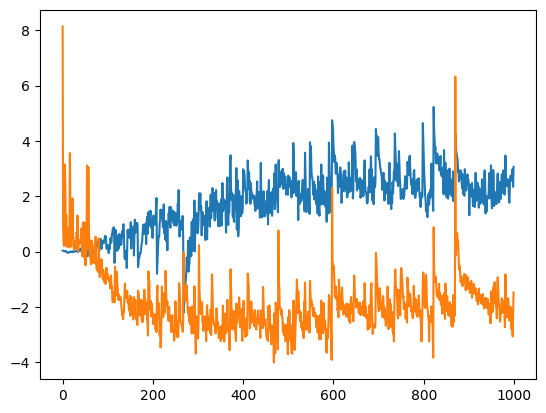

In [ ]:
plt.plot(generator_losses[:1000])
plt.plot(critic_losses[:1000])